In [6]:
# standard library
import os
from os import path
import sys
_path = path.abspath('../pkg/')
if _path not in sys.path:
    sys.path.append(_path)
import pickle

# Third-party
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join
from astropy.stats import knuth_bin_width
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
from scipy.stats import binned_statistic_2d

import gala.potential as gp
import gala.dynamics as gd

from chemtrails.potential import Sech2Potential
from chemtrails.data import (load_nominal_galah, load_nominal_apogee, get_catalog_name,
                             get_abundance_data, get_label_from_abundancename)

In [3]:
def make_panel(ax, galcen, abundance_name, 
               vlim=50.*u.km/u.s, vstep=4*u.km/u.s,
               zlim=1*u.kpc, zstep=25*u.pc):
    z_unit = u.kpc
    v_unit = u.km/u.s
    
    vlim = vlim.to(v_unit).value
    zlim = zlim.to(z_unit).value
    vstep = vstep.to(v_unit).value
    zstep = zstep.to(z_unit).value
    
    abun = get_abundance_data(g, abundance_name)
    abun_mask = np.isfinite(abun) & (np.abs(abun) < 2)

    abun = abun[abun_mask]
    galcen = galcen[abun_mask]
    
    if len(abun) <= 1:
        return None

    z = galcen.z.to(z_unit).value
    vz = galcen.v_z.to(v_unit).value

    stat = binned_statistic_2d(vz, z, abun, statistic='mean',
                               bins=(np.arange(-vlim, vlim+1e-3, vstep),
                                     np.arange(-zlim, zlim+1e-3, zstep)))
    
    vmin, vmax = np.percentile(abun, [15, 85])
    ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, 
                  cmap='magma', vmin=vmin, vmax=vmax)
    
    return stat

# GALAH

In [4]:
g, galcen = load_nominal_galah('/Users/adrian/data/GaiaDR2/GALAH-GaiaDR2-xmatch.fits',
                               zlim=np.inf*u.kpc, vzlim=np.inf*u.km/u.s)
survey = 'galah'

# ocl = Table.read('/Users/adrian/data/Misc/Dias+2002-Open-cluster.fits')
# ocl = ocl[ocl['Dist'] < 1500.]
# ocl_c = coord.SkyCoord(ra=np.array(ocl['RAJ2000'])*u.deg, 
#                        dec=np.array(ocl['DEJ2000'])*u.deg)

# c = g.get_skycoord(distance=False)
# idx, sep, _ = coord.match_coordinates_sky(c, ocl_c)
# ocl_mask = sep > 1*u.deg

# g = g[ocl_mask]
# galcen = galcen[ocl_mask]
len(g)

22928

In [5]:
all_elems = []
for col in g.data.colnames:
    if (col.endswith('_fe') and not col.startswith('e_') 
            and not col.startswith('flag') and not col.startswith('alpha')):
        col = '{}_h'.format(col.split('_')[0])
        all_elems.append(col)
        
all_elems = ['fe_h', 'alpha_fe'] + sorted(all_elems)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


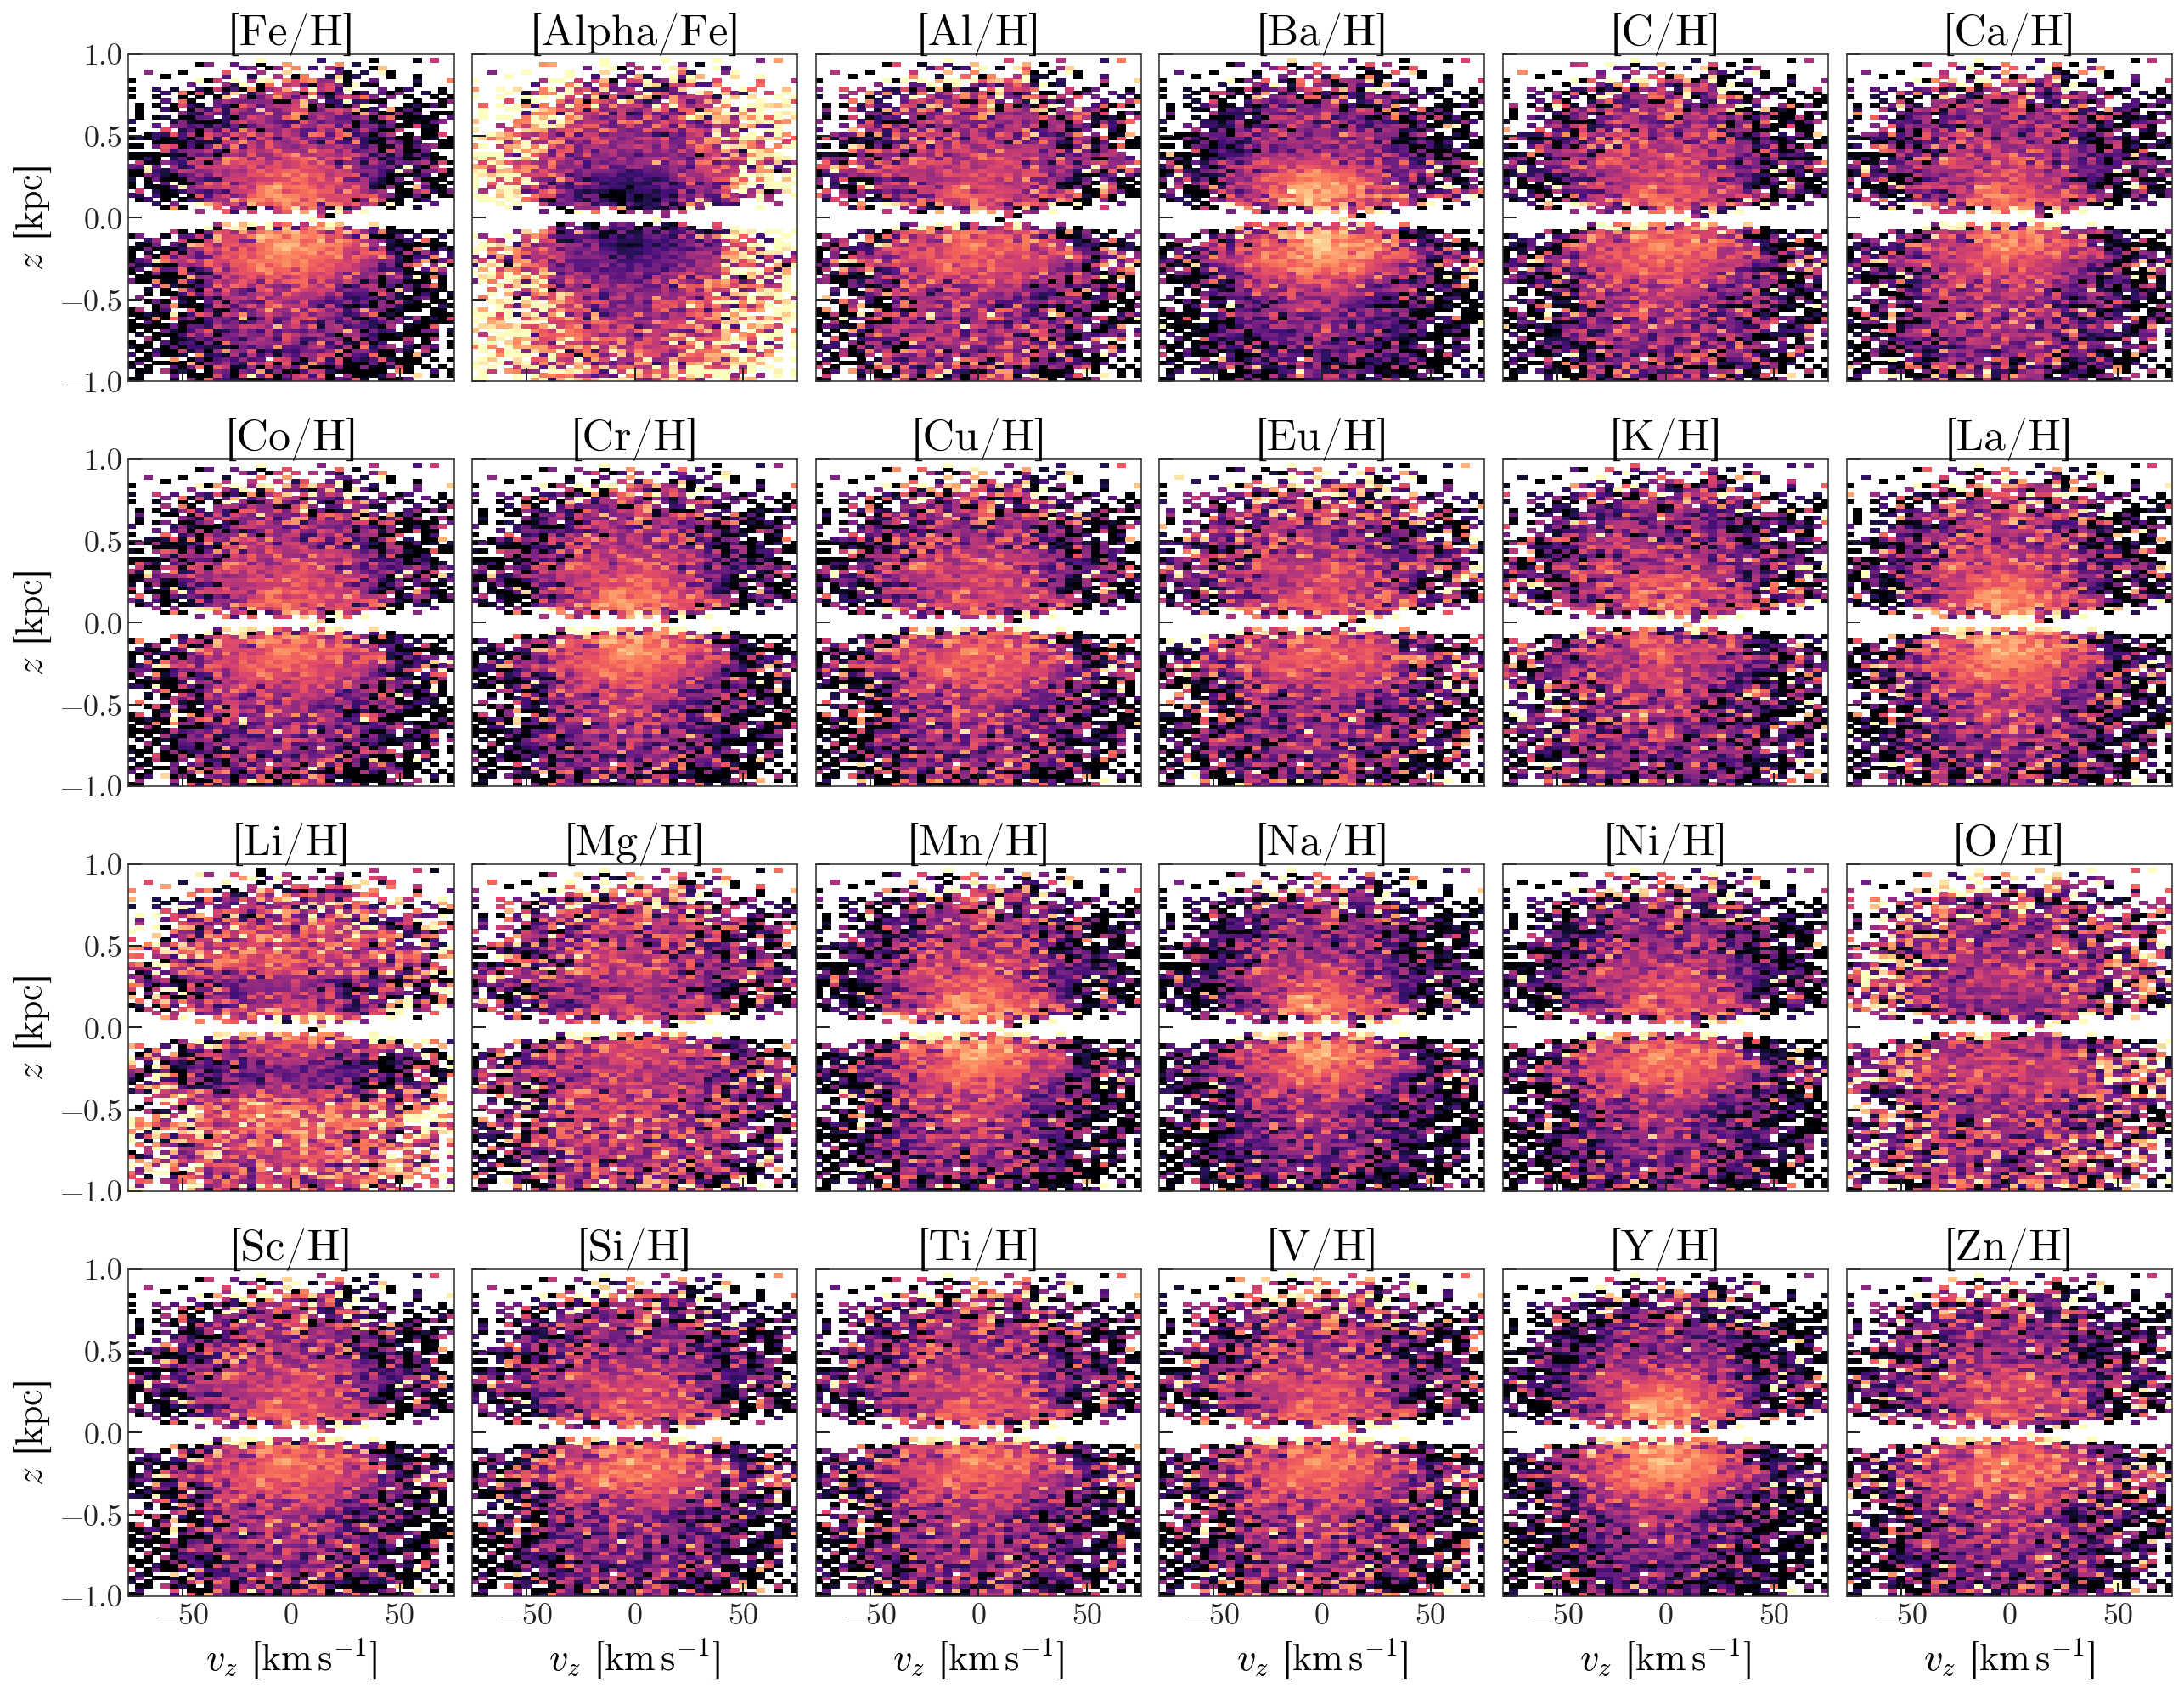

In [11]:
fig, axes = plt.subplots(4, 6, figsize=(18, 12+2), 
                         sharex=True, sharey=True)

assert len(axes.flat) == len(all_elems)

for k, elem in enumerate(all_elems):
    ax = axes.flat[k]
    stat = make_panel(ax, galcen, elem,
                      zlim=2*u.kpc,
                      vlim=100*u.km/u.s)
    ax.set_title(get_label_from_abundancename(elem))
ax.set_xlim(-75, 75)
ax.set_ylim(-1., 1.)

for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('$z$ [kpc]')
    
for i in range(axes.shape[1]):
    axes[-1, i].set_xlabel('$v_z$ [{0:latex_inline}]'.format(u.km/u.s))
    
fig.tight_layout()

fig.savefig('{0}-zvz.png'.format(survey), dpi=250)

In [7]:
H = gp.Hamiltonian(Sech2Potential(Sigma=65*u.Msun/u.pc**2,
                                  hz=250*u.pc))
n_Ez_bins = 5
edges = np.linspace(-3, 3, n_Ez_bins+1)

for elem in all_elems:
    print(elem)
    
    if elem == 'alpha_fe':
        lim = 1
    else:
        lim = 2
    
    abun = get_abundance_data(g, elem)
    mask = np.isfinite(abun)
    
    abun = abun[mask]
    _galcen = galcen[mask]
    
    pot0 = H.potential
    Ez = (0.5*_galcen.v_z**2 + pot0.energy(_galcen.z[None])) / 1000.

    x = np.log(Ez.value)
    x = x - np.mean(x)
    
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(2, 5)
    ax1 = fig.add_subplot(gs[0, :])
    _ax = fig.add_subplot(gs[1, 0])
    axes = [_ax] + [fig.add_subplot(gs[1, k], sharex=_ax, sharey=_ax) 
                    for k in range(1, n_Ez_bins)]
    [plt.setp(ax.get_yticklabels(), visible=False) for ax in axes[1:]]

    ax1.plot(x, abun, marker='o', ms=1, 
             mew=0, color='k', ls='none', alpha=0.25)
    
    # _min, _max = np.percentile(abun, [1, 99])
    for edg in edges:
        ax1.axvline(edg, marker='', color='tab:blue', zorder=-100)
    
    for i, l, r in zip(range(n_Ez_bins), edges[:-1], edges[1:]):
        ax = axes[i]
        
        bin_mask = (x > l) & (x <= r)
        abun_bins = np.arange(-lim, lim+1e-3, knuth_bin_width(abun[bin_mask]))
        ax.hist(abun[bin_mask], bins=abun_bins, color='#aaaaaa')
        
        mu = np.mean(abun[bin_mask])
        var = np.var(abun[bin_mask])
        ax.axvline(mu, color='k', alpha=0.75)
        ax.axvline(mu + 2*np.sqrt(var), color='k', 
                   alpha=0.5, linestyle='dashed')
        ax.axvline(mu - 2*np.sqrt(var), color='k', 
                   alpha=0.5, linestyle='dashed')
        
        ax.set_yscale('log')
    
    ax1.set_xlabel(r'$\ln E_z - {\rm mean}(\ln E_z)$')
    ax1.set_ylabel(get_label_from_abundancename(elem))
    axes[2].set_xlabel(get_label_from_abundancename(elem))
    
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-lim, lim)
    ax1.xaxis.set_ticks(np.arange(-3, 3+1e-3, 1))
    ax1.yaxis.set_ticks(np.arange(-lim, lim+1e-3, 1))
    
    fig.tight_layout()
    fig.savefig('Ez-trend-hist-{0}.png'.format(elem), dpi=250)
    plt.close(fig)

fe_h
alpha_fe
al_h
ba_h
c_h
ca_h
co_h
cr_h
cu_h
eu_h
k_h
la_h
li_h
mg_h
mn_h
na_h
ni_h
o_h
sc_h
si_h
ti_h
v_h
y_h
zn_h


# APOGEE

In [4]:
# g, galcen = load_nominal_apogee('/Users/adrian/data/GaiaDR2/Gaia_Apogee_RC_Crossmatch_all.fits',
g, galcen = load_nominal_apogee('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits',
                                zlim=np.inf*u.kpc, vlim=np.inf*u.km/u.s)
# survey = 'apogee-rc'
survey = 'apogee'

# cls_mask = (g.Classification == 'RC_Pristine')
cls_mask = np.ones(len(g), dtype=bool)
d_mask = np.isfinite(g.distance) & (g.distance < d_lim)
snr_mask = (g.SNR > snr_lim)
mask = cls_mask & d_mask & snr_mask

g = g[mask]
galcen = galcen[mask]
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


38349

In [5]:
all_elems = []
for col in g.data.colnames:
    col = col.lower()
    
    if col in ['ge_fe', 'tiii_fe']:
        continue
    
    if (col.endswith('_fe') and not col.startswith('e_') 
            and not col.startswith('flag') and not col.startswith('alpha')):
        col = '{}_h'.format(col.split('_')[0])
        all_elems.append(col)
        
all_elems = ['fe_h', 'alpha_m'] + sorted(all_elems)
len(all_elems)

24

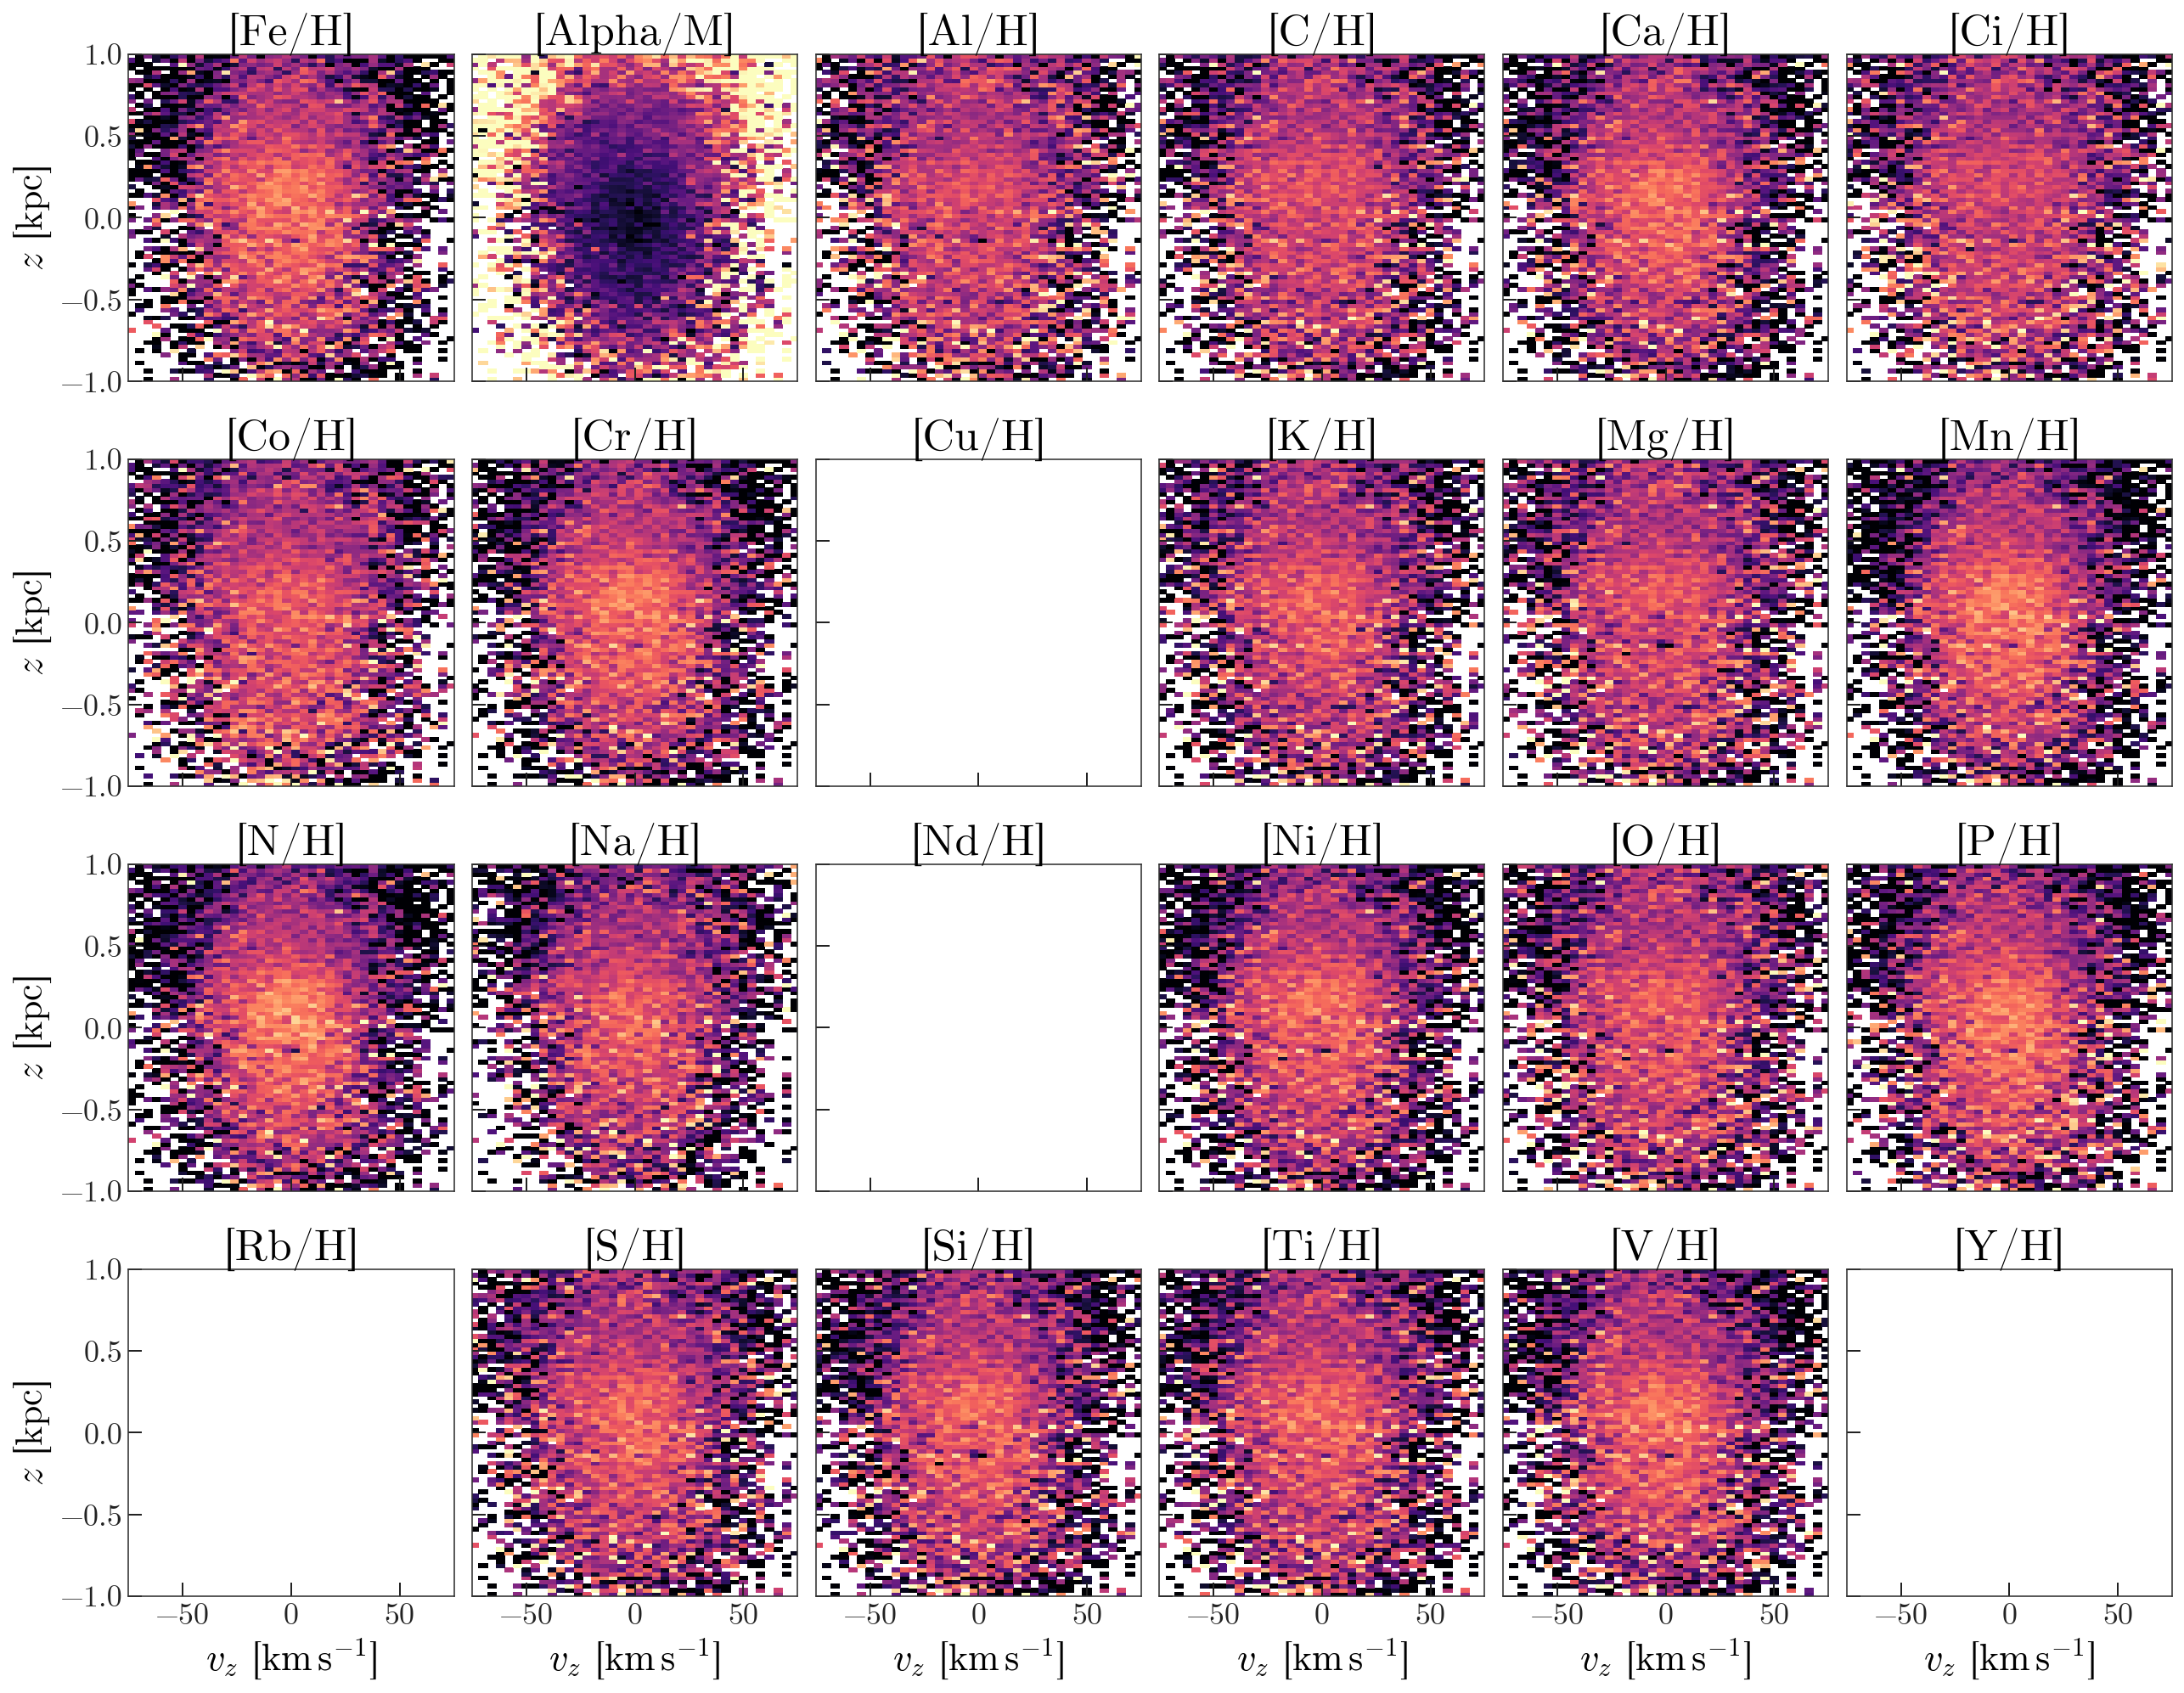

In [6]:
fig, axes = plt.subplots(4, 6, figsize=(18, 12+2), 
                         sharex=True, sharey=True)

assert len(axes.flat) == len(all_elems)

for k, elem in enumerate(all_elems):
    ax = axes.flat[k]
    stat = make_panel(ax, galcen, elem,
                      zlim=2*u.kpc,
                      vlim=100*u.km/u.s)
    ax.set_title(get_label_from_abundancename(elem))
ax.set_xlim(-75, 75)
ax.set_ylim(-1., 1.)

for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('$z$ [kpc]')
    
for i in range(axes.shape[1]):
    axes[-1, i].set_xlabel('$v_z$ [{0:latex_inline}]'.format(u.km/u.s))
    
fig.tight_layout()

fig.savefig('{0}-zvz.png'.format(survey), dpi=250)